### Reducing membrane affinity to restore plasma membrane association

Context:
- PAR-2(GCN4) displays strong localisation to internal membranes and reduced plasma membrane association
- Models predict that redicing the membrane affinity of monomers should increase membrane association for PAR-2(GCN4) by increasing membrane exchange kinetics. Conversely, the opposite should be true for PAR-2(wt) as membrane exchange kinetics are not limiting
- We mutate 2 residues in the PRBH domain of PAR-2 to reduce membrane affinity

Results:
- As expected, PRBH mutation reduced membrane affinity of PAR-2(wt), but has a modest _increase_ in affinity for PAR-2(GCN4)

Dependencies:
- Relies on quantification data generated by _Run/par2_nebd_quantify.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

from src import (
    add_stats_table_row,
    bootstrap_effect_size_pd,
    bounded_mean_1d,
    dataplot,
    lighten,
    load_image,
    nb_setup,
    raw_data_path,
    rotated_embryo,
    save_img,
)

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

### Quantification

In [2]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Filter relevant data
lines = ["lp637", "nwg495", "nwg489", "nwg376"]
df = df[df.Line.isin(lines) & (df.RNAi == "wt")]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    ratio_post = mem_post / cyt
    mem_frac = (
        0.5
        * bounded_mean_1d(group["Membrane signal"], [0.75, 0.25])
        / ((cyt / 0.174) + mem_tot)
    )
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
            "Ratio post": ratio_post,
            "Mem_frac": mem_frac,
        }
    )


df_summary = df_quantification.groupby("EmbryoID").apply(calculate_summary)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add genotype column
genotype_dict = {
    "lp637": "WT",
    "nwg495": "PRBH",
    "nwg489": "PRBH+GCN4",
    "nwg376": "GCN4",
}
df["Genotype"] = df["Line"].map(genotype_dict)

### Plot: fraction at posterior PM

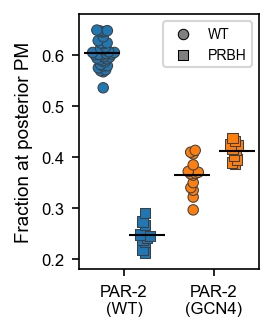

In [3]:
# Set up figure
fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Color pallete
palette1 = {"WT": "tab:blue", "GCN4": "tab:orange"}
palette2 = {"PRBH": lighten("tab:blue"), "PRBH+GCN4": lighten("tab:orange")}
palette2 = {"PRBH": "tab:blue", "PRBH+GCN4": "tab:orange"}

# Plot non PRBH data
dataplot(
    data=df[df.Genotype.isin(["WT", "GCN4"])],
    x="Genotype",
    y="Mem_frac",
    ax=ax,
    linewidth=0.5,
    hue="Genotype",
    palette=palette1,
    transform=trans + offset(-10),
    offset=-0.25,
    order=["WT", "GCN4"],
    marker="o",
)

# Plot PRBH data
dataplot(
    data=df[df.Genotype.isin(["PRBH", "PRBH+GCN4"])],
    x="Genotype",
    y="Mem_frac",
    ax=ax,
    linewidth=0.5,
    hue="Genotype",
    palette=palette2,
    transform=trans + offset(10),
    offset=0.25,
    order=["PRBH", "PRBH+GCN4"],
    marker="s",
)

# Legend
dot1 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors="k", color="tab:gray", s=25)
dot2 = ax.scatter(
    x=[], y=[], linewidth=0.5, edgecolors="k", color="tab:gray", s=25, marker="s"
)
ax.legend([dot1, dot2], ["WT", "PRBH"], fontsize=6.7, loc="upper right")

# Finalise figure
ax.set_xticklabels(["PAR-2\n(WT)", "PAR-2\n(GCN4)"])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0.18, 0.68)
ax.set_ylabel("Fraction at posterior PM", fontsize=9)
fig.set_size_inches(2, 2.5)
fig.subplots_adjust(left=0.3, bottom=0.2)

# Save figure
fig.savefig("Figs/fraction_prbh.png", dpi=600, transparent=True)
fig.savefig("Figs/fraction_prbh.pdf", transparent=True)

# SourceData
df.to_csv("../../../data/EMBO_source_data/5H.csv", index=False)

In [4]:
# Effect of GCN4 in non-PRBH conditions
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="Genotype", y="Mem_frac", a="WT", b="GCN4"
)
add_stats_table_row(
    figure="5",
    panel="H",
    sample_a="PAR-2(WT)",
    sample_b="PAR-2(GCN4)",
    measure="Fraction at posterior PM (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="3Cu4RWlApP",
)

# Effect of GCN4 in PRBH conditions
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="Genotype", y="Mem_frac", a="PRBH", b="PRBH+GCN4"
)
add_stats_table_row(
    figure="5",
    panel="H",
    sample_a="PAR-2(PRBH)",
    sample_b="PAR-2(GCN4,PRBH)",
    measure="Fraction at posterior PM (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="24RVkaAmKz",
)

# Effect of PRBH in WT conditions
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="Genotype", y="Mem_frac", a="WT", b="PRBH"
)
add_stats_table_row(
    figure="5",
    panel="H",
    sample_a="PAR-2(WT)",
    sample_b="PAR-2(PRBH)",
    measure="Fraction at posterior PM (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="AqG0zqQGky",
)

# Effect of PRBH in GCN4 conditions
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="Genotype", y="Mem_frac", a="GCN4", b="PRBH+GCN4"
)
add_stats_table_row(
    figure="5",
    panel="H",
    sample_a="PAR-2(GCN4)",
    sample_b="PAR-2(GCN4,PRBH)",
    measure="Fraction at posterior PM (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="YeEWf0t8dF",
)

### Images

/app/src/../raw_data//Imaging/par2_nebd/220825_nwg495_tom4,15,60/05
/app/src/../raw_data//Imaging/par2_nebd/220805_nwg489_tom4,15,60/00


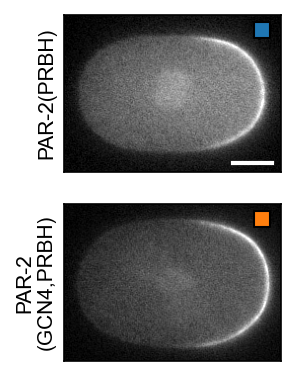

In [5]:
def panel(path, ax, scale_bar=False):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 220, 160, 3)
    ax.imshow(rotated, cmap="gray", vmin=0, vmax=np.percentile(rotated, 99.9))
    ax.set_xticks([])
    ax.set_yticks([])

    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot(
            [rotated.shape[1] - 10 - bar_pixels, rotated.shape[1] - 10],
            [y, y],
            color="w",
            linewidth=2,
        )


if raw_data_path:
    # Specify paths
    path_prbh = raw_data_path + df[df.Line == "nwg495"].Path.to_list()[0]
    path_prbh_gcn4 = raw_data_path + df[df.Line == "nwg489"].Path.to_list()[0]
    print(path_prbh)
    print(path_prbh_gcn4)

    # Create figure
    fig, ax = plt.subplots(2, 1)
    panel(path_prbh, ax[0], scale_bar=True)
    panel(path_prbh_gcn4, ax[1])

    # Format figure
    ax[0].set_ylabel("PAR-2(PRBH)", fontsize=10)
    ax[1].set_ylabel("PAR-2\n(GCN4,PRBH)", fontsize=10)
    ax[0].scatter(200, 15, c="tab:blue", s=60, edgecolors="k", marker="s")
    ax[1].scatter(200, 15, c="tab:orange", s=60, edgecolors="k", marker="s")
    fig.set_size_inches(2.5, 3)

    # Save figure
    fig.savefig("Figs/imgs_prbh.png", dpi=600, transparent=True)
    fig.savefig("Figs/imgs_prbh.pdf", transparent=True)

    # SourceData
    os.makedirs("../../../data/EMBO_source_data/5G", exist_ok=True)
    save_img(
        load_image(path_prbh + "/af_corrected.tif"),
        "../../../data/EMBO_source_data/5G/PRBH.tif",
    )
    save_img(
        load_image(path_prbh_gcn4 + "/af_corrected.tif"),
        "../../../data/EMBO_source_data/5G/PRBH_GCN4.tif",
    )